In [ ]:
%load_ext autoreload
%autoreload 2
from functions.pytorch_functions import *
from tqdm import tqdm
import pickle

In [ ]:
ds_all, ds_all_centered, datasets, datasets_centered, ds_counts = load_data()

In [ ]:
seq_len = 49
index_start = 0
# index_start = np.random.randint(0,len(ds_all_centered)-seq_len)
print("Seeding with frame {}".format(index_start))
xtest = ds_all_centered[index_start:index_start+seq_len]
animation = animate_stick(xtest, 
                          figsize=(10,8), 
                          cmap='inferno', 
                          cloud=False
                         )
HTML(animation.to_html5_video())

# Convert to NRI format

### Start with creating the train & validation sets...

In [ ]:
ds_all_centered = ds_all_centered.reshape((38309,3,53))
print(ds_all_centered.shape)

In [ ]:
n_simulations = 500
seq_length = 49
nodes = []
velocities = []
edges = []

start = 0
for n in range(n_simulations):
    start += seq_length+1
    sequence = ds_all_centered[start:start+seq_length]
    nodes.append(sequence)
    velocities.append(np.vstack([np.zeros((1,3,53)),np.stack([(sequence[i+1] - sequence[i])*35 for i in range(seq_length-1)])])) # first velocity is always 0, I guess
    edges.append(np.ones((53,53))) # fully-connected

nodes = np.stack(nodes)
velocities = np.stack(velocities)
edges = np.stack(edges)

In [ ]:
print(nodes.shape)
print(velocities.shape)
print(edges.shape)

In [ ]:
def unison_shuffled_copies(a, b, c):
    assert len(a) == len(b) == len(c)
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p]

In [ ]:
nodes, velocities, edges = unison_shuffled_copies(nodes, velocities, edges) # shuffle all of them in the same way

In [ ]:
train_index = int(n_simulations*(.8)) # first 80% go to the training set; remaining 20% go to the validation set
print(train_index)

In [ ]:
np.save("../NRI/data/loc_train_dance.npy", nodes[:train_index])
np.save("../NRI/data/vel_train_dance.npy", velocities[:train_index])
np.save("../NRI/data/edges_train_dance.npy", edges[:train_index])

np.save("../NRI/data/loc_valid_dance.npy", nodes[train_index:])
np.save("../NRI/data/vel_valid_dance.npy", velocities[train_index:])
np.save("../NRI/data/edges_valid_dance.npy", edges[train_index:])

Preview the samples you just saved:

In [ ]:
nodes = np.load("../NRI/data/loc_train_dance.npy")
velocities = np.load("../NRI/data/vel_train_dance.npy")
edges = np.load("../NRI/data/edges_train_dance.npy")

animation = animate_stick(nodes[1].reshape((xtest.shape)), figsize=(10,8), cmap='inferno', cloud=False)
HTML(animation.to_html5_video())

### Now make the test set, with a longer sequence length (1000 timesteps), starting after timestep 49*500 = 24,500

In [ ]:
(38309-24500)/1000

In [ ]:
n_simulations = 12
seq_length = 1000
nodes = []
velocities = []
edges = []
start = 24500

for n in range(n_simulations):
    start += seq_length+1
    sequence = ds_all_centered[start:start+seq_length]
    nodes.append(sequence)
    velocities.append(np.vstack([np.zeros((1,3,53)),np.stack([(sequence[i+1] - sequence[i])*35 for i in range(seq_length-1)])])) # first velocity is always 0, I guess
    edges.append(np.ones((53,53))) # fully-connected

nodes = np.stack(nodes)
velocities = np.stack(velocities)
edges = np.stack(edges)

In [ ]:
print(nodes.shape)
print(velocities.shape)
print(edges.shape)

In [ ]:
np.save("../NRI/data/loc_test_dance.npy", nodes)
np.save("../NRI/data/vel_test_dance.npy", velocities)
np.save("../NRI/data/edges_test_dance.npy", edges)

Preview the test set you just saved:

In [ ]:
nodes = np.load("../NRI/data/loc_test_dance.npy") 
velocities = np.load("../NRI/data/vel_test_dance.npy")
edges = np.load("../NRI/data/edges_test_dance.npy")

In [ ]:
animation = animate_stick(nodes[0].reshape((1000,53,3)), figsize=(10,8), cmap='inferno', cloud=False)
HTML(animation.to_html5_video())

# Visualize the NRI training outputs

In [5]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import pickle
predicted_outputs = pickle.load(open("../NRI/logs/dance_250epochs/predicted_outputs.txt", "rb"))
actual_outputs = pickle.load(open("../NRI/logs/dance_250epochs/actual_outputs.txt", "rb"))

actual = actual_outputs[0][0,:,:,:3]
actual = np.transpose(actual, [1, 2, 0])

pred = predicted_outputs[0][0,:,:,:3]
pred = np.transpose(pred, [1, 2, 0])

actual = actual.reshape((20,53,3))
pred = pred.reshape((20,53,3))

In [ ]:
animation = animate_stick(actual, 
                          ghost=pred, 
                          figsize=(10,8), cmap='inferno')
HTML(animation.to_html5_video())

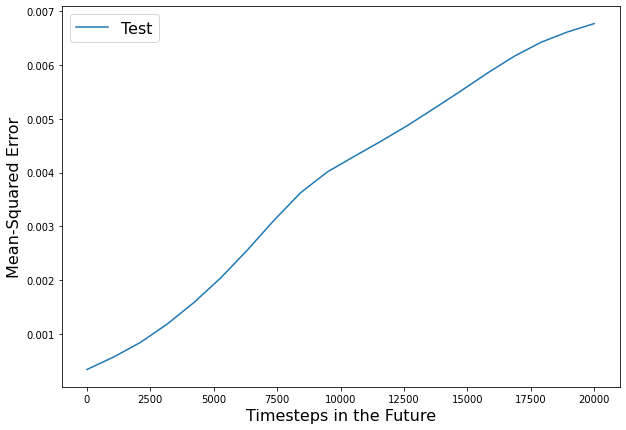

In [24]:
mse_test = [ 0.000337863894 , 0.000569751021 , 0.000840535213 , 0.001180468476 , 0.001579841599 , 0.002035367070 , 0.002553931205 , 0.003107692348 , 0.003623061813 , 0.004009141121 , 0.004296756815 , 0.004578069318 , 0.004871356301 , 0.005190063268 , 0.005514046643 , 0.005848178174 , 0.006159576122 , 0.006420182064 , 0.006612744182 , 0.006768682506 ]
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(np.linspace(0,len(mse_test)*1000,20), mse_test, label="Test")
ax.set_xlabel("Timesteps in the Future", fontsize=16)
ax.set_ylabel("Mean-Squared Error", fontsize=16)
ax.legend(fontsize=16)

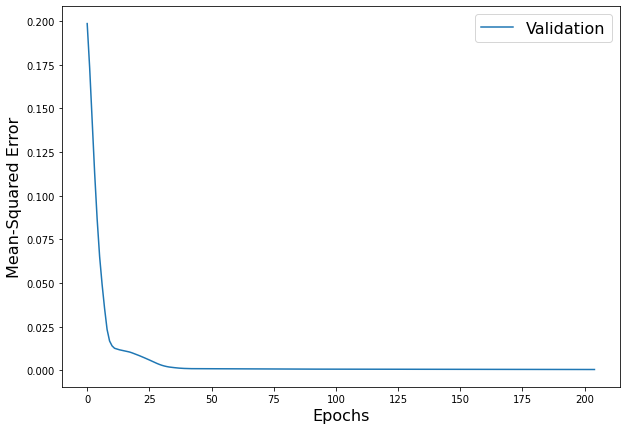

In [29]:
mse_val = [0.1985629797,0.1730879396,0.1424342394,0.1129891947,0.0867334306,0.0651665106,0.0491816886,0.0354032069,0.0234651826,0.0168670025,0.0140645234,0.0126876300,0.0122165810,0.0118077099,0.0114783766,0.0112006161,0.0108778579,0.0105574643,0.0100935455,0.0095420601,0.0090124831,0.0084489658,0.0078192661,0.0072438526,0.0066445502,0.0059939935,0.0053296452,0.0046722828,0.0040471884,0.0034665596,0.0029584155,0.0025502117,0.0022203960,0.0019567029,0.0017642714,0.0016075233,0.0014557041,0.0013222282,0.0012207478,0.0011448750,0.0010886523,0.0010471749,0.0010204784,0.0010136792,0.0010053384,0.0009795692,0.0009758105,0.0009729589,0.0009614107,0.0009526493,0.0009448236,0.0009318838,0.0009233282,0.0009217858,0.0009174432,0.0009035217,0.0008959490,0.0008957117,0.0008942565,0.0008840684,0.0008754164,0.0008734678,0.0008729949,0.0008677421,0.0008562242,0.0008491043,0.0008466687,0.0008433846,0.0008373906,0.0008321531,0.0008311191,0.0008310130,0.0008200273,0.0008119582,0.0008089118,0.0008086908,0.0008025524,0.0007959726,0.0007913178,0.0007902170,0.0007838566,0.0007715687,0.0007701280,0.0007680004,0.0007630836,0.0007613782,0.0007567342,0.0007562892,0.0007539855,0.0007493485,0.0007462697,0.0007446230,0.0007435887,0.0007412342,0.0007369507,0.0007327907,0.0007309802,0.0007260019,0.0007201259,0.0007171400,0.0007163984,0.0007117960,0.0007079190,0.0007069991,0.0007053206,0.0007005377,0.0006948150,0.0006935751,0.0006904854,0.0006862998,0.0006861060,0.0006841625,0.0006808146,0.0006797123,0.0006796088,0.0006755175,0.0006706867,0.0006685929,0.0006662707,0.0006611502,0.0006588390,0.0006585711,0.0006521909,0.0006491622,0.0006485938,0.0006475612,0.0006424676,0.0006397422,0.0006381946,0.0006339625,0.0006312610,0.0006304442,0.0006272433,0.0006239768,0.0006214220,0.0006201507,0.0006156504,0.0006137837,0.0006114083,0.0006083620,0.0006077517,0.0006041283,0.0006007819,0.0005990516,0.0005960749,0.0005939692,0.0005898118,0.0005877268,0.0005851102,0.0005822491,0.0005815662,0.0005785917,0.0005759307,0.0005759111,0.0005754770,0.0005720837,0.0005696203,0.0005687728,0.0005682722,0.0005672809,0.0005663651,0.0005658095,0.0005655174,0.0005649544,0.0005641121,0.0005633154,0.0005626641,0.0005619964,0.0005613188,0.0005606212,0.0005598944,0.0005591792,0.0005584945,0.0005577578,0.0005570282,0.0005562847,0.0005555556,0.0005548481,0.0005541602,0.0005534518,0.0005527497,0.0005520358,0.0005513608,0.0005506784,0.0005500022,0.0005493087,0.0005486266,0.0005479535,0.0005472607,0.0005465778,0.0005458925,0.0005452034,0.0005445124,0.0005438614,0.0005432211,0.0005425686,0.0005418967,0.0005412316,0.0005405763,0.0005399099,0.0005392428,0.0005385856,0.0005379461,0.0005372981,0.0005366532]
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(np.arange(len(mse_val)), mse_val, label="Validation")
ax.set_xlabel("Epochs", fontsize=16)
ax.set_ylabel("Mean-Squared Error", fontsize=16)
# ax.set_yscale('log')
ax.legend(fontsize=16)